# Halite using Distributed Evolutionary Algorithms

[More detailed (non-Halite specific) tutorial](https://github.com/DEAP/notebooks/blob/master/OneMax.ipynb)

Below is a starter package you can use to help train your [halite](www.halite.io) bot using  [DEAP](https://github.com/DEAP/deap)

Many halite bots rely of hard-coded values or heuristics that may not be optimized. And many of these values interact with each other so training them individually may be hard. Evolutionary algorithms may help

In [1]:
import random
from deap import base, creator, tools, algorithms

### Type Creation
Create individual types and fitness functions

In [2]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

### Create bots
Our individual bot will take a list of parameters which we can later use to initalize our bots

In [3]:
ind = creator.Individual([1.])

print(ind)
print(type(ind))
print(type(ind.fitness))

[1.0]
<class 'deap.creator.Individual'>
<class 'deap.creator.FitnessMax'>


Now we'll register the attributes that will be used in our bot, individual bots and population. In this bot, we'll have 2 parameters: prod_attr and default_dir_attr. prod_attr will be a float from 1 to 10 and default_dir_attr will be an int from 0 to 3. When we initialize our bot to test, it will take these 2 parameters and run a game with given values. These two parameters are what we're solving for.

In [27]:
min_prod_attr_val = 1
max_prod_attr_val = 10
min_default_dir = 0
max_default_dir = 4

toolbox = base.Toolbox()
toolbox.register("prod_attr", random.uniform, min_prod_attr_val, max_prod_attr_val)
toolbox.register("default_dir_attr", random.randint, min_default_dir, max_default_dir)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.prod_attr, toolbox.default_dir_attr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

An attribute consists of its value. 
An individual consists of a list of attributes. 
A population consists of a list of individuals.

In [28]:
bit = toolbox.prod_attr()
ind = toolbox.individual()
pop = toolbox.population(n=3)

print("bit is of type %s and has value\n%s" % (type(bit), bit))
print("ind is of type %s and contains %d bits\n%s" % (type(ind), len(ind), ind))
print("pop is of type %s and contains %d individuals\n%s" % (type(pop), len(pop), pop))


bit is of type <class 'float'> and has value
3.411705090209399
ind is of type <class 'deap.creator.Individual'> and contains 2 bits
[8.058465779581912, 1]
pop is of type <class 'list'> and contains 3 individuals
[[1.9086151005759628, 0], [8.699548868466799, 1], [6.214087347039889, 2]]


### Evaluation Function
Define the criteria by which to evaluate an individual. This can be anything, but to keep it simple, lets just use how fast our individual can solve a map given in a one player game. This can be expanded to incorporate how the bot fares against other bots, an averaging of several maps or more complex evaluation methods based on accumulated strength/production/territory. Fitness is negative since we want to maximize fitness which means minimizing number of moves. But, of course, this can be changed.

For the bot, I use optparse to send parameters to the bot. You may need to edit eval function below to work with a specific bot. And this should be expanded to be a more robust measure of fitness, but it is important to have a controlled environment to test the bot for puroposes of comparison (e.g. each individual has the same map and positioning)

In [37]:
import subprocess

def evalIndividual(individual, seed="123456789", map_size="30 30"):
    halite_file = "./halite"
    opt_1 = "-d"
    opt_1_val = map_size
    opt_2 = "-s"
    opt_2_val = seed
    
    ### EDIT THIS ###
    bot = "EvoBot.py"
    bot_opts = ["-p", "-d"]
    bot_vals = individual
    bot_command = "python3 {}".format(bot)
    #################
    
    for opt, val in zip(bot_opts, bot_vals):
        bot_command += " {} {}".format(opt, val)

    out = subprocess.run([halite_file, opt_1, opt_1_val, opt_2, opt_2_val, bot_command],
                         stdout=subprocess.PIPE)
    out = out.stdout.splitlines()
    out = [line.decode("utf-8") for line in out]

    return [-max([int(line.split()[-1]) for line in out if "Turn" in line])]

Register evaluation function. For mating, we'll cross the individuals. This doesn't make sense for an individual with attributes of length 1, but this can be expanded to more attributes. The mutate is set to a gaussian with a 0 mean and individual probability of mutation of 10%

In [38]:
toolbox.register("evaluate", evalIndividual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1., indpb=0.10)
toolbox.register("select", tools.selTournament, tournsize=1)

Test mutation below. Note that running mutate has only a 10% probability of mutating each attribute

In [40]:
ind = toolbox.individual()
print(ind)
toolbox.mutate(ind)
print(ind)

[8.422174901637693, 0]
[10.794272078776203, 0]


## Evolving

In [41]:
import numpy
def main():
    pop = toolbox.population(n=5)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, 
                                       ngen=10, stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof

Although we got some improvement in the first generation, later generations have not improved. This is a simple example and the parameters used have a relatively small impact on the overall performance of the bot. Also, the evaluation function is very simple.

gen	nevals	avg 	min 	max 
0  	5     	-251	-300	-175
1  	5     	-202.8	-300	-174
2  	4     	-200.6	-300	-174
3  	2     	-202.8	-300	-174
4  	0     	-228  	-300	-180
5  	4     	-276  	-300	-180
6  	4     	-276  	-300	-180
7  	1     	-276  	-300	-180
8  	1     	-276  	-300	-180
9  	2     	-276  	-300	-180
10 	4     	-276  	-300	-180
Best individual is: [4.848321376101778, 3]
with fitness: (-174.0,)


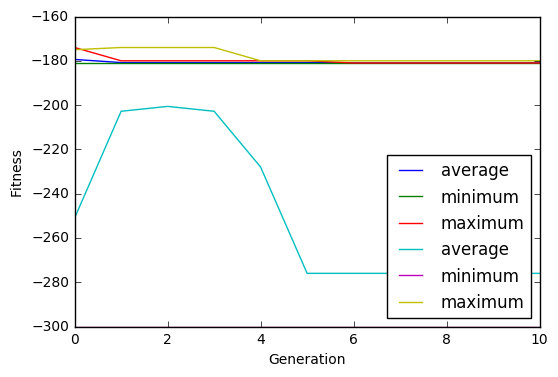

In [42]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    pop, log, hof = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    
    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")

plt.show()